In [172]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

class TwentyFortyEightEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode=None,log_reward = True):
        super().__init__()
        self.board_size = 4
        self.log_reward = log_reward
        # Actions: 0 = up, 1 = down, 2 = left, 3 = right
        self.action_space = spaces.Discrete(4)

        # Board is 4x4 integers; observation is a flattened vector of size 16
        self.observation_space = spaces.Box(
            low=0,
            high=2**16,
            shape=(1,4,4),
            dtype=np.int32
        )

        self.render_mode = render_mode
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int32)
        self.score = 0

        self._add_tile()
        self._add_tile()

        return self._get_obs(), {}

    def get_mask(self):
        return [
            self._move_up(test_is_masked=True),
            self._move_down(test_is_masked=True),
            self._move_left(test_is_masked=True),
            self._move_right(test_is_masked=True),

        ]

    def step(self, action):
        old_board = self.board[:][:]
        if action == 0:
            reward = self._move_up()
        elif action == 1:
            reward = self._move_down()
        elif action == 2:
            reward = self._move_left()
        elif action == 3:
            reward = self._move_right()

        # # Invalid move (board unchanged)
        if np.array_equal(self.board, old_board):
            done = True
            reward = -10**10
        else:
            # Only add a tile after a valid move
            self._add_tile()
            done = not self._moves_available()

        return self._get_obs(), reward, done, False, {"score": self.score}

    # -------- Rendering -------- #

    def render(self):
        print("\nScore:", self.score)
        print("-" * 25)
        for row in self.board:
            print("|" + "|".join(f"{num:^5}" if num != 0 else "     " for num in row) + "|")
            print("-" * 25)

    # -------- Helper Methods -------- #

    def _get_obs(self):
        return self.board
    
    def _add_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if not empty:
            return
        i, j = random.choice(empty)
        self.board[i, j] = 4 if random.random() < 0.1 else 2

    def _moves_available(self):
        if np.any(self.board == 0):
            return True
        for i in range(4):
            for j in range(4):
                if j < 3 and self.board[i, j] == self.board[i, j + 1]:
                    return True
                if i < 3 and self.board[i, j] == self.board[i + 1, j]:
                    return True
        return False

    # -------- Movement Logic -------- #

    def _compress(self, row):
        new = row[row != 0]
        return np.concatenate([new, np.zeros(4 - len(new), dtype=np.int32)])

    def _merge(self, row):
        score_gain = 0
        for i in range(3):
            if row[i] != 0 and row[i] == row[i + 1]:
                row[i] *= 2
                row[i + 1] = 0
                score_gain += np.log2(row[i]) if self.log_reward else row[i]
        return row, score_gain

    def _move_left(self,test_is_masked = False):
        total_gain = 0
        new_board = np.zeros((self.board_size, self.board_size), dtype=np.int32)
        old_board = self.board.copy()
        for i in range(4):
            row = self._compress(self.board[i])
            row, gain = self._merge(row)
            row = self._compress(row)
            new_board[i] = row
            total_gain += gain
        if test_is_masked:
            self.board = old_board
            return  np.array_equal(self.board,new_board)
        self.board = new_board
        self.score += total_gain
        return float(total_gain)

    def _move_right(self,test_is_masked = False):
        self.board = np.fliplr(self.board)
        reward = self._move_left(test_is_masked=test_is_masked)
        self.board = np.fliplr(self.board)
        if test_is_masked:
            return reward
        return reward

    def _move_up(self,test_is_masked = False):
        self.board = self.board.T
        reward = self._move_left(test_is_masked=test_is_masked)
        self.board = self.board.T
        if test_is_masked:
            return reward
        return reward

    def _move_down(self,test_is_masked = False):
        self.board = self.board.T
        reward = self._move_right(test_is_masked=test_is_masked)
        self.board = self.board.T
        if test_is_masked:
            return reward
        return reward


In [173]:
# env = TwentyFortyEightEnv()
# env.reset()
# for _ in range(50):
#     print(env.board)
#     _,_,_,_,_ =env.step(1)
#     print(env.get_mask())
#     print(f'reward is {r}')
    

In [174]:
import os
import time
import random
from dataclasses import dataclass

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from cleanrl.cleanrl_utils.buffers import ReplayBuffer


#####################################################################
# =======================  CONFIG  =================================
#####################################################################

@dataclass
class DQNConfig:
    exp_name: str = "exp_0"
    seed: int = 1
    cuda: bool = True
    torch_deterministic: bool = True

    # Env
    env_id: str = "TwentyFortyEightEnv"

    # Learning
    learning_rate: float = 5e-5
    buffer_size: int = 100_000
    batch_size: int = 32
    gamma: float = 0.99
    tau: float = 1.0
    target_freq: int = 1000
    train_freq: int = 4
    learning_starts: int = 10_000
    # Exploration
    start_eps: float = 1.0
    end_eps: float = 0.05
    exploration_fraction: float = 0.2


#####################################################################
# =======================  UTILS  ==================================
#####################################################################

def linear_schedule(start, end, duration, t):
    if t >= duration:
        return end
    return start + (end - start) * (t / duration)


#####################################################################
# =======================  NETWORK  ================================
#####################################################################

class QNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 16),
            nn.ReLU(),
            nn.Linear(16, act_dim)
        )

    def forward(self, x):
        return self.net(x.float())



#####################################################################
# =======================  AGENT API ===============================
#####################################################################

class DQNAgent:
    def __init__(self, env: gym.Env, config: DQNConfig):
        self.env = env
        self.cfg = config

        obs_dim = np.prod(env.observation_space.shape)
        act_dim = env.action_space.n

        # device setup
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() and config.cuda else "cpu"
        )

        # seeds
        random.seed(config.seed)
        np.random.seed(config.seed)
        torch.manual_seed(config.seed)

        if config.torch_deterministic:
            torch.backends.cudnn.deterministic = True

        # networks
        self.q = QNetwork(obs_dim, act_dim).to(self.device)
        self.q_target = QNetwork(obs_dim, act_dim).to(self.device)
        self.q_target.load_state_dict(self.q.state_dict())

        self.optimizer = optim.Adam(self.q.parameters(), lr=config.learning_rate)

        # replay buffer
        self.rb = ReplayBuffer(
            config.buffer_size,
            env.observation_space,
            env.action_space,
            self.device,
            handle_timeout_termination=False,
        )

        self.global_step = 0
        self.start_time = time.time()

    #################################################################
    # ===================   ACTION LOGIC   ==========================
    #################################################################

    def act(self, obs, epsilon):
        """ epsilon-greedy """
        mask = env.get_mask()
        if random.random() < epsilon:
            legal = np.where([not x for x in mask])
            return np.random.choice(legal[0])
        obs_t = torch.tensor(obs.copy(), device=self.device).unsqueeze(0).unsqueeze(0)

        with torch.no_grad():
            qvals = self.q(obs_t)
        
        mask = torch.tensor(mask,device = qvals.device)

        qvals = torch.masked_fill(qvals,mask,-float('inf'))
        return qvals.argmax().cpu().numpy()

    #################################################################
    # ===================   TRAIN STEP    ===========================
    #################################################################

    def train_step(self):
        cfg = self.cfg

        data = self.rb.sample(cfg.batch_size)

        with torch.no_grad():
            next_q = self.q_target(data.next_observations)
            max_next_q = next_q.max(dim=1)[0]
            td_target = data.rewards.flatten() + cfg.gamma * max_next_q * (1 - data.dones.flatten())

        current_q = (
            self.q(data.observations)
            .gather(1, data.actions)
            .squeeze()
        )

        loss = F.mse_loss(current_q, td_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    #################################################################
    # ===================   TRAIN LOOP    ===========================
    #################################################################

    def train(self, total_timesteps):
        cfg = self.cfg
        obs, _ = self.env.reset(seed=cfg.seed)
        
        ep_return = 0
        ep_length = 0

        # eps decay
        eps_decay_timesteps = int(cfg.exploration_fraction * total_timesteps)

        print(f"===== Training for {total_timesteps:,} timesteps =====")
        rewards = []
        for self.global_step in range(total_timesteps):

            ###############################################
            # ACTION
            ###############################################
            eps = linear_schedule(cfg.start_eps, cfg.end_eps, eps_decay_timesteps, self.global_step)
            action = self.act(obs, eps)

            next_obs, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            # add to replay buffer
            self.rb.add(obs, next_obs, action, reward, terminated, info)

            ep_return += reward
            ep_length += 1

            obs = next_obs

            ###############################################
            # TRAINING
            ###############################################
            if self.global_step > cfg.learning_starts:
                if self.global_step % cfg.train_freq == 0:
                    loss = self.train_step()

                # update target
                if self.global_step % cfg.target_freq == 0:
                    with torch.no_grad():
                        for p, p_targ in zip(self.q.parameters(), self.q_target.parameters()):
                            p_targ.data.copy_(cfg.tau * p.data + (1 - cfg.tau) * p_targ.data)

            ###############################################
            # LOGGING
            ###############################################
            if done:
                print(
                    f"[step {self.global_step}]  "
                    f"Return: {ep_return:.1f}   "
                    f"Length: {ep_length}   "
                    f"Eps: {eps:.3f}   "
                    f"SPS: {int(self.global_step / (time.time() - self.start_time))}"
                )
                rewards.append(ep_return)
                ep_return = 0
                ep_length = 0
                obs, _ = self.env.reset()
        return rewards
        print("===== Training Complete =====")

    #################################################################
    # ===================   PREDICT API   ===========================
    #################################################################

    def predict(self, obs):
        print('start')
        obs_t = torch.tensor(obs.copy(), device=self.device).unsqueeze(0).unsqueeze(0)
        print(obs_t.shape)
        with torch.no_grad():
            qvals = self.q(obs_t)
        print(qvals)
        mask = torch.tensor(env.get_mask(),device = qvals.device)
        qvals = torch.masked_fill(qvals,mask,-float('inf'))
        return int(qvals.argmax().item())

    #################################################################
    # ===================   SAVE / LOAD   ===========================
    #################################################################

    def save(self, path):
        torch.save(self.q.state_dict(), path)

    def load(self, path):
        self.q.load_state_dict(torch.load(path, map_location=self.device))
        self.q_target.load_state_dict(self.q.state_dict())


In [175]:
cfg = DQNConfig()
env = TwentyFortyEightEnv(log_reward=False)     # your custom env

agent = DQNAgent(env, cfg)
rewards = agent.train(1_000_000)
agent.save("dqn_2048.pt")

===== Training for 1,000,000 timesteps =====
[step 247]  Return: 3032.0   Length: 248   Eps: 0.999   SPS: 2416
[step 481]  Return: 2912.0   Length: 234   Eps: 0.998   SPS: 2425
[step 552]  Return: 544.0   Length: 71   Eps: 0.997   SPS: 2430
[step 609]  Return: 340.0   Length: 57   Eps: 0.997   SPS: 2438
[step 728]  Return: 1088.0   Length: 119   Eps: 0.997   SPS: 2445
[step 910]  Return: 2244.0   Length: 182   Eps: 0.996   SPS: 2451
[step 1062]  Return: 1448.0   Length: 152   Eps: 0.995   SPS: 2453
[step 1153]  Return: 708.0   Length: 91   Eps: 0.995   SPS: 2456
[step 1230]  Return: 568.0   Length: 77   Eps: 0.994   SPS: 2455
[step 1330]  Return: 748.0   Length: 100   Eps: 0.994   SPS: 2455
[step 1403]  Return: 532.0   Length: 73   Eps: 0.993   SPS: 2459
[step 1486]  Return: 548.0   Length: 83   Eps: 0.993   SPS: 2460
[step 1582]  Return: 716.0   Length: 96   Eps: 0.992   SPS: 2458
[step 1697]  Return: 1060.0   Length: 115   Eps: 0.992   SPS: 2461
[step 1845]  Return: 1420.0   Length: 

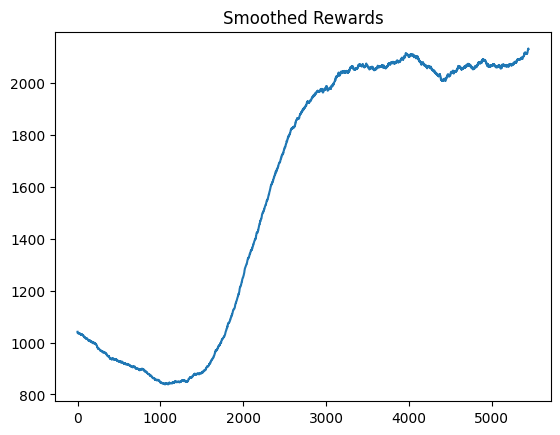

In [181]:
import numpy as np
import matplotlib.pyplot as plt

window = 1000
smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.plot(smooth)
plt.title("Smoothed Rewards")
plt.show()


In [ ]:
import numpy as np


env = TwentyFortyEightEnv(log_reward=False)
obs, _ = env.reset()

done = False
total_reward = 0

while not done:
    
    action = agent.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

    print(env.board)
    print("Action:", action)
    print("Reward:", total_reward)
    print("maks",env.get_mask())
    x = input("Press Enter for next step...")
    if x == 'X':
        break

print("Final Score:", env.score)


start
torch.Size([1, 1, 4, 4])
tensor([[1160.3162, 1126.2025, 1163.3198, 1083.8329]], device='cuda:0')
[[2 0 2 0]
 [0 0 0 0]
 [0 0 0 0]
 [2 0 0 0]]
Action: 2
Reward: 0.0
maks [False, False, False, False]


start
torch.Size([1, 1, 4, 4])
tensor([[1161.9746, 1127.7056, 1164.3185, 1085.1843]], device='cuda:0')
[[4 0 0 0]
 [0 0 2 0]
 [0 0 0 0]
 [2 0 0 0]]
Action: 2
Reward: 4.0
maks [False, False, False, False]
start
torch.Size([1, 1, 4, 4])
tensor([[1168.4236, 1136.0615, 1172.2894, 1092.2030]], device='cuda:0')
[[4 0 0 0]
 [2 0 2 0]
 [0 0 0 0]
 [2 0 0 0]]
Action: 2
Reward: 4.0
maks [False, False, False, False]
start
torch.Size([1, 1, 4, 4])
tensor([[1179.1365, 1146.4840, 1182.3513, 1101.2257]], device='cuda:0')
[[4 0 0 0]
 [4 0 0 0]
 [0 2 0 0]
 [2 0 0 0]]
Action: 2
Reward: 8.0
maks [False, False, False, False]
start
torch.Size([1, 1, 4, 4])
tensor([[1176.5763, 1142.4946, 1176.9795, 1095.7042]], device='cuda:0')
[[4 0 0 0]
 [4 0 2 0]
 [2 0 0 0]
 [2 0 0 0]]
Action: 2
Reward: 8.0
maks [False, False, False, False]
start
torch.Size([1, 1, 4, 4])
tensor([[1186.3276, 1153.6495, 1188.2305, 1106.6891]], device='cuda:0')
[[4 0 0 0]
 [4 2 0 0]
 [2 0 0 0]
 [2 0 0 2]]
Action: 2
Reward: 8.0
maks [False, F